# 1 : Librairies et Options

In [1]:
# Librairies diverses :
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import numpy as np
import timeit
import datetime
import statistics
import random
import gc
import json
import requests

# Librairies modéles ML :
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.preprocessing import OneHotEncoder
from lightgbm.sklearn import LGBMClassifier
import lightgbm as lgb

# Librairies pour MLFLOW : 
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
#mlflow.autolog()

# Mesures ML :
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.metrics import make_scorer

# Largeur du fichier Jupyter Notebook :
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran

# Longeur et largeur de l'affichage des DF :
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.display.width = 50
pd.options.display.max_colwidth = 1000

# Suppression des warnings pour SHAP :
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
import shap
shap.initjs()

# Pour ne pas avoir de message d'erreur quand on crée nouvelle Clients à partir d'une autre (app)
pd.set_option('mode.chained_assignment', None) 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 2 :  Définitions pour le ML

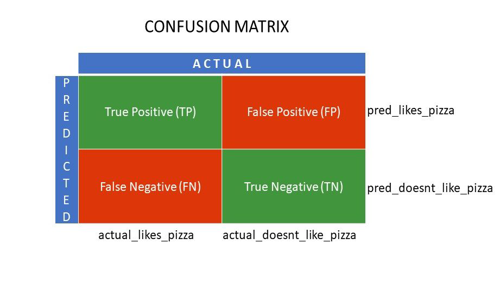

In [2]:
# Schéma d'une matrice de confusion (vive les pizzas) :
image = Image.open('basic_cm-edited.jpg')
image.resize((500, 300))

In [3]:
# Split des données :
def TrainTest(X, y) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y)
    return X_train, X_test, y_train, y_test

In [4]:
# Definition Metrics :

def Accuracy(model, X_train, X_test) :
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    AccuracyTrain = round((accuracy_score(y_train, y_pred_train)),3)
    AccuracyTest = round((accuracy_score(y_test, y_pred_test)),3)
    return AccuracyTrain, AccuracyTest

def AUC(model, X_train, X_test) :
    ROCTrain = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    ROCTest = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return ROCTrain, ROCTest

# Mesure personnalisée pour mettre du poid sur les Faux Negatifs plus couteux pour l'entreprise :
def custom_metric(y_true, proba):
    Bestproba = 12
    Bestscore = 10
    for j in range(0,21):
        y_pred = []
        for i in proba :
            if i >= j/20 :
                y_pred.append(1)
            else :
                y_pred.append(0)
        
        cm = confusion_matrix(y_true, y_pred)
        mesure = round(((cm[1][0]*10 + cm[0][1])/(11*(len(y_true)))),3)
        if mesure < Bestscore :
            Bestscore = mesure
            Bestproba = j/20
    
    return Bestscore

custom_score = make_scorer(custom_metric, greater_is_better = False, needs_proba=True)

In [5]:
# Récupération de la meilleure proba :
def bestproba(y_true, proba):
    Bestproba = 12
    Bestscore = 10
    for j in range(0,21):
        y_pred = []
        for i in proba :
            if i >= j/20 :
                y_pred.append(1)
            else :
                y_pred.append(0)
        
        cm = confusion_matrix(y_true, y_pred)
        mesure = round(((cm[1][0]*10 + cm[0][1])/(11*(len(y_true)))),3)
        if mesure < Bestscore :
            Bestscore = mesure
            Bestproba = j/20
    
    return Bestproba

BP = make_scorer(bestproba, needs_proba=True)

In [6]:
# Dico des scores pour le scoring :
scoring = {"BestScore": custom_score, "BestProba": BP}

In [7]:
# Definition de récupération des résultats sur MLFlow :

def MLFLOW(model, X_train, X_test, name) : 
    
    # Lieu :
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Nom du projet :
    mlflow.set_experiment('MLFlowP7 - Optimisation')

    with mlflow.start_run() as run:

        # Nom du RUN (Date) :
        mlflow.set_tag("mlflow.runName", datetime.datetime.today().strftime('%Y-%m-%d'))

        # Timer : 
        start_time = timeit.default_timer()

        # Appel du model :
        model.fit(X_train, y_train) 

        # Fin du Timer :
        elapsed = timeit.default_timer() - start_time
        mlflow.log_metric("Duree Run", elapsed)

        # On calcule le score du modèle sur le test :
            # Récupération des paramètres du model :
        mlflow.log_params(model.get_params())
        
        # Nb Variables utilisées :
        nbcolonnes = len(X_train.columns)
        mlflow.log_metric('Nb Variables', nbcolonnes)

        # Récupération des métrics :
            # Accuracy Score : 
        TrainAcc, TestAcc = Accuracy(model, X_train, X_test)
        mlflow.log_metric("Accuracy Train", TrainAcc)
        mlflow.log_metric("Accuracy Test", TestAcc)

            # ROC AUC Score :
        TrainAUC, TestAUC = AUC(model, X_train, X_test)
        mlflow.log_metric("AUC Train", round(TrainAUC,3))
        mlflow.log_metric("AUC Test", round(TestAUC,3))
        
            # Metric perso :
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        TrainMP = custom_metric(y_train, y_pred_train)
        TestMP = custom_metric(y_test, y_pred_test)
        mlflow.log_metric("Metric Perso Train", round(TrainMP,3))
        mlflow.log_metric("Metric Perso Test", round(TestMP,3))
        
            # BestProba :
        proba = model.predict_proba(X_train)
        proba = pd.DataFrame(proba)[1].to_numpy()
        BP = bestproba(y_train, proba)
        mlflow.log_metric("Metric Best Pourcentage", round(BP,3))
        
        # Récupération des graphiques :
            # Matrice de Confusion :
        cm = confusion_matrix(y_test, y_pred_test, labels = model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
        plt.title ('Matrice de Confusion pour le model {}.'.format(str(model).split('(')[0]))
        disp.plot(ax=ax1) 
        mlflow.log_figure(fig, "ConfMat.png")
        plt.close(fig)

            # ROC Curve :
        pred = model.predict_proba(X_test)[::,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
        fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
        plt.title ('ROC Curve pour le model {}.'.format(str(model).split('(')[0]))
        display.plot(ax=ax1)
        mlflow.log_figure(fig, "ROCCurve.png")
        plt.close(fig)
        

        
        # Sauvegarde du model mais uniquement pour la 3éme étape (model final) :
        if name == 'Etape 3' :
            # La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction.
            signature = infer_signature(X_train, y_train)
            
            # Sauvegarde du model :
            mlflow.sklearn.log_model(
                sk_model = model.best_estimator_,
                artifact_path = "sklearn-model",
                signature = signature,
                registered_model_name = "sk-learn-LGBMClassifier") 
        else :
            pass
        
        # Fin du RUN :
        mlflow.end_run()
        
        # Récupération des résultats pour mettre dans un tableau visible en python :
        Resultats = [name, round(elapsed), nbcolonnes, TrainAcc, TestAcc, round(TrainAUC,3), round(TestAUC,3), TrainMP, TestMP, BP]
        return Resultats

# 3 : Machine Learning

## 3.1 : Ouverture des données nettoyées

In [8]:
Data = pd.read_csv('OldDataP7.csv')
Data.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,...,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.000000,19.0,0.000000,0.000,0.000000,0.000,0.000000e+00,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.000000,25.0,0.000000,0.000,0.000000,0.000,0.000000e+00,560835.360,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,26.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.000000,3.0,0.000000,0.000,0.000000,0.000,0.000000e+00,10573.965,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-

In [9]:
# JSON name non pris en compte pour le LGBM :
Data = Data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [10]:
NaN = (Data.isna().mean()*100).astype(int)
NaN = pd.DataFrame(NaN)
print('Il y a', len(NaN[NaN[0] >= 60]), 'variables avec plus de 60% de NaNs.')
print('Il y a', len(NaN[NaN[0] >= 50]), 'variables avec plus de 50% de NaNs.')
print('Il y a', len(NaN[NaN[0] >= 40]), 'variables avec plus de 40% de NaNs.')
print('Il y a', len(NaN[NaN[0] >= 30]), 'variables avec plus de 30% de NaNs.')

Il y a 212 variables avec plus de 60% de NaNs.
Il y a 236 variables avec plus de 50% de NaNs.
Il y a 245 variables avec plus de 40% de NaNs.
Il y a 253 variables avec plus de 30% de NaNs.


In [11]:
# Variables avec moins de 50% de NaNs :
VarNaNs = list(NaN[NaN[0] < 50].index)

In [12]:
# Garder que les colonnes avec moins de 50% de NaN pour avoir un modèle dégradé mais plus rapide :
Data = Data[VarNaNs]

In [13]:
# Exporter ce nouveau fichier :
Data.to_csv('OldDataP7s.csv', index = False)

## 3.2 : Création des X, y et des Test/Train pour les modèles

In [14]:
# Variables pour l'analyse en ML
y = Data['TARGET']
X = Data.iloc[:,1:]

In [15]:
# Split des données : 
X_train, X_test, y_train, y_test = TrainTest (X, y)

## 3.3 : Amélioration du modèle LGBM

In [16]:
# Step 1: Trouver le bon learning rate et le bon n estimator.

SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
dico1 = {'learning_rate': [0.1, 0.01], 'n-estimators': [100, 1000]}
modelLGB1 = GridSearchCV(LGBMClassifier(random_state = 42, class_weight={0:1, 1:12}, verbose=-1, objective="binary"), dico1, scoring = scoring, cv = SKF, refit = "BestScore", n_jobs = -1)
Resultat1 = MLFLOW(modelLGB1, X_train, X_test, 'Etape 1')
BestEstimator = modelLGB1.best_params_['n-estimators']
BestLearningRate = modelLGB1.best_params_['learning_rate']

2023/09/04 20:28:01 INFO mlflow.tracking.fluent: Experiment with name 'MLFlowP7 - Optimisation' does not exist. Creating a new experiment.


In [17]:
# Step 2: Tune max_depth and min_child_weight.

SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
dico2 = {'max_depth': [3, 5, 7], 'min_child_weight': [1, 3]}
modelLGB2 = GridSearchCV(LGBMClassifier(random_state = 42, learning_rate = BestLearningRate, n_estimators = BestEstimator, class_weight={0:1, 1:12}, verbose=-1, objective="binary"), dico2, scoring = scoring, cv = SKF, refit = "BestScore", n_jobs = -1)
Resultat2 = MLFLOW(modelLGB2, X_train, X_test, 'Etape 2')
BestDepth = modelLGB2.best_params_['max_depth']
Bestminchildweight = modelLGB2.best_params_['min_child_weight']

In [18]:
# Step 3: Tuning regularization parameters.

SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train)
dico3 = {'reg_alpha':np.arange(0, 1, 0.2), 'reg_lambda': range(0,10,2)}
modelLGB3 = GridSearchCV(LGBMClassifier(n_jobs = -1, random_state = 42, learning_rate = BestLearningRate, n_estimators = BestEstimator, max_depth = BestDepth, min_child_weight = Bestminchildweight, class_weight={0:1, 1:12}, verbose=-1, objective="binary"), dico3, scoring = scoring, cv = SKF, refit = "BestScore")
Resultat3 = MLFLOW(modelLGB3, X_train, X_test, 'Etape 3')
Bestregalpha = modelLGB3.best_params_['reg_alpha']
Bestreglambda = modelLGB3.best_params_['reg_lambda']

Setuptools is replacing distutils.
Successfully registered model 'sk-learn-LGBMClassifier'.
2023/09/04 21:07:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-LGBMClassifier, version 1
Created version '1' of model 'sk-learn-LGBMClassifier'.


In [19]:
# Récapitulatif :
df = pd.DataFrame()
df = pd.concat([df, pd.DataFrame(Resultat1).T])
df = pd.concat([df, pd.DataFrame(Resultat2).T])
df = pd.concat([df, pd.DataFrame(Resultat3).T])

df.columns = ['N°Etape', 'DureeModel', 'NbVariablesUtilisées', 'AccuracyTrain', 'AccuracyTest', 'AUCTrain', 'AUCTest', 'CustomeTrain', 'CustomTest', 'BestPourcentProba']
df

,N°Etape,DureeModel,NbVariablesUtilisées,AccuracyTrain,AccuracyTest,AUCTrain,AUCTest,CustomeTrain,CustomTest,BestPourcentProba
0,Etape 1,313,559,0.729,0.717,0.833,0.777,0.039,0.046,0.5
0,Etape 2,328,559,0.729,0.717,0.831,0.778,0.039,0.046,0.5
0,Etape 3,1646,559,0.729,0.717,0.831,0.778,0.039,0.046,0.5


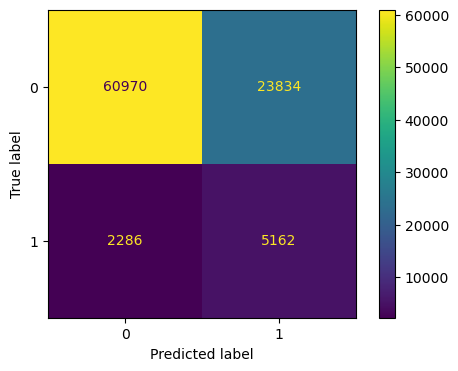

In [20]:
y_predict = modelLGB3.predict(X_test)
cm = confusion_matrix(y_test, y_predict, labels = modelLGB3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
disp.plot(ax=ax1);

# 3.4 : Exporter le model en pickle et le réimporter (non utilisé pour ce projet mais intéressant à garder)

In [21]:
# Exporter le meilleur model :
import pickle

filename = 'ModelGrid.sav'
pickle.dump(modelLGB3.best_estimator_, open(filename, 'wb'))

In [22]:
# Télécharger le meilleur moodel :
loaded_model = pickle.load(open('ModelGrid.sav', 'rb'))
result = loaded_model.predict_proba(X_test)
result = result[:, 1]
result.shape

(92252,)

# 3.5 : Staging du model :

In [23]:
from mlflow import MlflowClient
import mlflow
client = MlflowClient()
client.transition_model_version_stage(
    name = "sk-learn-LGBMClassifier", version = 1, stage="Production")

<ModelVersion: aliases=[], creation_timestamp=1693854454530, current_stage='Production', description='', last_updated_timestamp=1693854456397, name='sk-learn-LGBMClassifier', run_id='54e8e926154740e480c31ccecd7d78c7', run_link='', source='mlflow-artifacts:/904924831831418957/54e8e926154740e480c31ccecd7d78c7/artifacts/sklearn-model', status='READY', status_message='', tags={}, user_id='', version='1'>

# 4 : Feature Importances

## 4.1 : Via paramètre Feature Importances

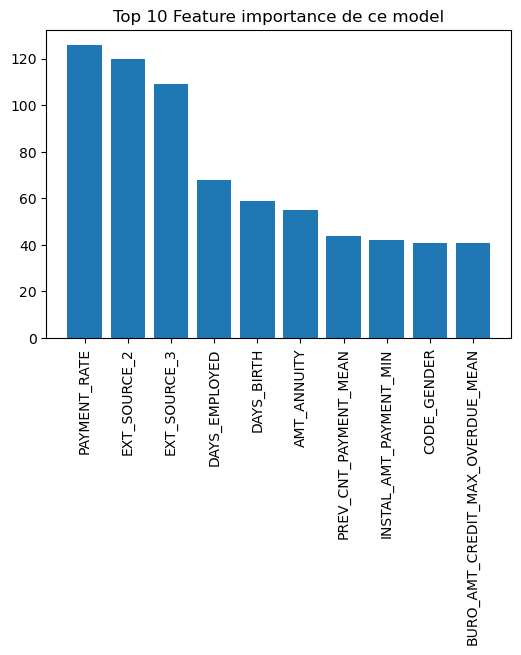

In [24]:
Importance = modelLGB3.best_estimator_.feature_importances_
Features = X.columns

df = pd.DataFrame((zip(Features, Importance)), columns = ['Variables', 'Importance'])
df = df.sort_values('Importance', ascending = False)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
ax1 = plt.bar(df['Variables'].head(10), df['Importance'].head(10))
ax1 = plt.xticks(rotation = 90)
ax1 = plt.title('Top 10 Feature importance de ce model')

plt.show()

 ## 4.2 : Via SHAP

100%|===================| 215233/215254 [22:11<00:00]        

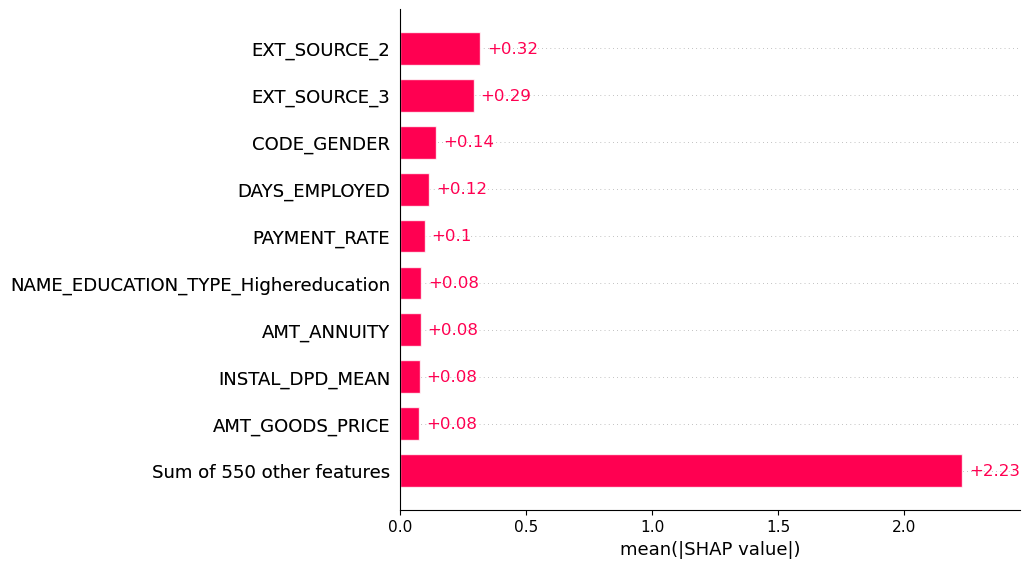

In [25]:
explainer = shap.TreeExplainer(modelLGB3.best_estimator_, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values, max_display = 10, show=False)
plt.savefig('SHAPGlobale.png', bbox_inches='tight')

# 5 : Nouveaux Clients et SHAP locale

In [26]:
# Nouveaux clients :
NewClients = pd.read_csv('NewDataP7.csv')
NewClients = NewClients.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
NewClients = NewClients[Data.columns]
del NewClients['TARGET']
NumNewClient = list(NewClients.reset_index(drop = True).index)
NewClient = random.choice(NumNewClient)
NewClient

42331

In [27]:
# Clients qui vient faire une demande pret :
NewClient = NewClients.iloc[NewClient : NewClient+1]
NewClient

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,...,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
42331,1.0,0.0,1.0,2.0,90000.0,651600.0,35478.0,562500.0,0.002134,-9067.0,-118.0,-3083.0,-1738.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0,3.0,3.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,0.544722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-545.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,162292.5,162292.5,162292.5,0.956052,0.956052,0.956052,NaN,15516.0,15516.0,15516.0,155160.0,155160.0,155160.0,9.0,9.0,9.0,0.095037,0.095037,0.095037,-545.0,-545.0,-545.0,6.0,6.0,1.0,0.0,0.0,0.0,35.0,16.333333,98.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,29753.1,29752.62,178515.72,29750.22,29753.1,29752.62,178515.72,-372.0,-454.333333,-2726.0,6.0


In [28]:
Z = modelLGB3.predict_proba(NewClient)
pd.DataFrame(Z)

,0,1
0,0.583348,0.416652


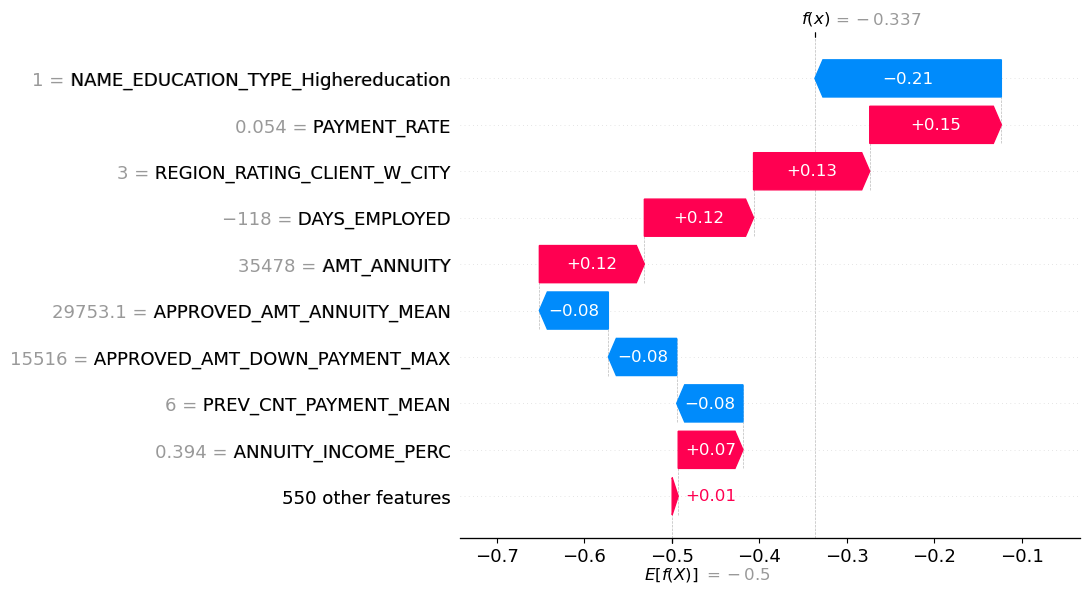

In [29]:
# Explainer :
explainer = shap.TreeExplainer(modelLGB3.best_estimator_, X_train)

# Visualisation :
shap_values = explainer(NewClient, check_additivity=False)
shap.waterfall_plot(shap_values[0], max_display = 10)

In [38]:
# Récupération des variables importantes:
BestVariables = pd.DataFrame(zip(shap_values[0].values, NewClient.columns))
BestVariables[0] = abs(BestVariables[0]).round(2)
BestVariables = BestVariables.sort_values(0, ascending = False)
BestVariables = list(BestVariables.iloc[:10][1])
BestVariables

['NAME_EDUCATION_TYPE_Highereducation',
 'PAYMENT_RATE',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'PREV_CNT_PAYMENT_MEAN',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ANNUITY_INCOME_PERC',
 'CODE_GENDER']

# 6 : Test prediction via MLFlow

In [30]:
New_Data = pd.read_csv('NewDataP7.csv')
New_Data = New_Data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
New_Data = New_Data.iloc[3:4][VarNaNs]
del New_Data['TARGET']
New_Data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,...,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
3,1.0,0.0,0.0,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.509677,0.612704,0.997,0.375,0.997,0.375,0.997,0.375,0.37,0.0,0.0,0.0,0.0,-1805.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,59521.5,225000.0,138429.0,0.0,1.108112,0.702704,0.373267,0.0,11250.0,5625.0,65956.5,130765.5,98361.0,9.0,13.0,11.0,0.0,0.173124,0.086562,-1805.0,-797.0,-1364.0,11.333333,34.0,3.0,7.0,0.265487,30.0,19.0,3.265487,369.0,1.0,0.911504,103.0,0.045393,8505.0,622.550708,70348.23,2.972476e+06,38988.54,4979.282257,562658.895,1.17,38988.54,4356.731549,492310.665,-29.0,-858.548673,-97016.0,113.0


In [31]:
# Prédiction sur model final :
model_name = "sk-learn-LGBMClassifier"
stage = "Production"

model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{stage}")

model.predict_proba(New_Data.values.tolist())

array([[0.67732258, 0.32267742]])

In [33]:
url = 'http://localhost:8080/api/'

data = New_Data.values.tolist()
j_data = json.dumps(data)
headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
r = requests.post(url, data=j_data, headers=headers)
result2 = float(r.text.split(' ')[1].split(']]')[0])
int(round(result2,2)*100)

32